In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.io import loadmat,savemat
from scipy.signal import deconvolve, savgol_filter


from plotnine import *
# import plotly

# import h5py

from scipy.spatial import KDTree
from scipy.ndimage.interpolation import shift


from utils import *

import os
os.environ['R_HOME'] = 'C:\\Users\\j_gav\\anaconda3\\envs\\analysis\\lib\\R'

from pymer4 import Lmer, Lm

savepath = './figures/'


In [2]:
df = pd.read_csv('./data/df_Behavior.csv')

df

,condition,isprobe,isfti,wait_times,probe_times,fti_time,subject,brief,event_times
0,RP,0,0,2.901075,NaN,NaN,33702,True,2.901075
1,RP,0,0,1.646512,NaN,NaN,33702,True,1.646512
2,RP,0,0,4.269728,NaN,NaN,33702,False,4.269728
3,RP,0,0,4.519402,NaN,NaN,33702,False,4.519402
4,Miss,1,0,NaN,3.725612,NaN,33702,False,3.725612
...,...,...,...,...,...,...,...,...,...
4635,RP,0,0,3.311247,NaN,NaN,33725,True,3.311247
4636,RP,0,0,4.831753,NaN,NaN,33725,False,4.831753
4637,Miss,1,0,NaN,2.685961,NaN,33725,False,2.685961
4638,RP,0,0,3.901750,NaN,NaN,33725,False,3.901750


# Simple behavior (means, averages, etc).

In [3]:
# Overall means
df.describe()

,isprobe,isfti,wait_times,probe_times,fti_time,subject,event_times
count,4640.000000,4640.000000,2813.000000,1827.000000,376.000000,4640.000000,4640.000000
mean,0.393750,0.081034,3.803282,4.066029,0.244038,33713.633621,3.906739
std,0.488633,0.272917,0.958785,1.029717,0.195069,6.847540,0.995527
min,0.000000,0.000000,0.177580,2.291776,-0.001959,33702.000000,0.177580
25%,0.000000,0.000000,3.199912,3.355988,0.097876,33708.000000,3.263593
50%,0.000000,0.000000,3.691273,3.818458,0.195221,33714.000000,3.753391
75%,1.000000,0.000000,4.314409,4.579815,0.335321,33720.000000,4.419048
max,1.000000,1.000000,8.375782,9.698724,0.943426,33725.000000,9.698724


In [4]:
# Means grouped by subjects
# How many are probes, FTI, etc
df.groupby('subject').mean().describe()

,isprobe,isfti,wait_times,probe_times,fti_time,brief,event_times
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.392674,0.082934,3.977747,3.928643,0.191750,0.348472,3.902990
std,0.182112,0.065176,0.665090,0.359032,0.099048,0.108660,0.405588
min,0.140000,0.020000,3.378790,3.382292,0.077865,0.077778,3.396056
25%,0.292812,0.033750,3.579396,3.687934,0.131447,0.298750,3.622103
50%,0.334444,0.062500,3.797397,3.926569,0.163647,0.370000,3.799301
75%,0.481250,0.106250,4.096895,4.106289,0.207685,0.418750,4.072016
max,0.855000,0.243750,5.908364,4.659897,0.460904,0.490000,4.820934


In [5]:
# Group by subject, value_count each condition, unstack the data & fill na (0 entries) with 0, then describe the dataframe
# Gets average
df[(~df.condition.isin(['RP']))].groupby(['subject'])['condition'].value_counts(normalize=True).unstack().fillna(0).describe()

condition,FTI,Hit,Miss,Unsure
count,24.000000,24.000000,24.000000,24.000000
mean,0.240705,0.268969,0.403663,0.086663
std,0.221329,0.215069,0.194563,0.077485
min,0.026144,0.000000,0.048780,0.000000
25%,0.109503,0.085074,0.299069,0.019094
50%,0.169981,0.247548,0.389129,0.063930
75%,0.254407,0.420234,0.483572,0.138064
max,0.951220,0.750000,0.813953,0.244186


In [6]:
df.groupby(['subject'])['condition'].value_counts().unstack().fillna(0).describe()

condition,FTI,Hit,Miss,RP,Unsure
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,15.666667,20.166667,33.291667,117.208333,7.000000
std,11.552025,17.211388,25.422481,35.388501,7.021705
min,4.000000,0.000000,2.000000,27.000000,0.000000
25%,6.750000,6.250000,17.000000,103.750000,1.000000
50%,12.000000,20.500000,27.500000,120.500000,5.500000
75%,19.750000,27.250000,47.000000,135.750000,10.000000
max,43.000000,67.000000,113.000000,172.000000,23.000000


In [7]:
df_temp = df[(~df.condition.isin(['RP']))].groupby(['subject'])['condition'].value_counts(normalize=True).unstack().fillna(0).describe()

In [7]:
df_temp = df['condition'].value_counts(normalize=True)

df_temp

RP        0.606250
Miss      0.172198
Hit       0.104310
FTI       0.081034
Unsure    0.036207
Name: condition, dtype: float64

In [15]:
df['errortrial'] = 0
df.loc[df.condition.isin(['RP']) & (df.wait_times < 2.5),'errortrial'] = 1

df.groupby(['subject']).mean().describe()

In [16]:
df['badfti'] = 0
df.loc[df.condition.isin(['FTI']) & (df.fti_time > 0.2),'badfti'] = 1

df.groupby(['subject']).mean().describe()

,isprobe,isfti,wait_times,probe_times,fti_time,brief,event_times,errortrial,badfti
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.392674,0.082934,3.977747,3.928643,0.191750,0.348472,3.902990,0.033715,0.040405
std,0.182112,0.065176,0.665090,0.359032,0.099048,0.108660,0.405588,0.028980,0.054097
min,0.140000,0.020000,3.378790,3.382292,0.077865,0.077778,3.396056,0.000000,0.000000
25%,0.292812,0.033750,3.579396,3.687934,0.131447,0.298750,3.622103,0.008750,0.005000
50%,0.334444,0.062500,3.797397,3.926569,0.163647,0.370000,3.799301,0.030625,0.017500
75%,0.481250,0.106250,4.096895,4.106289,0.207685,0.418750,4.072016,0.051250,0.061667
max,0.855000,0.243750,5.908364,4.659897,0.460904,0.490000,4.820934,0.100000,0.193750


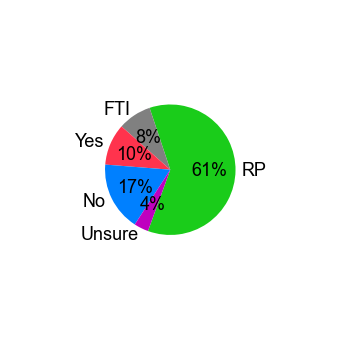

In [22]:
df_temp = pd.DataFrame({
    'condition':['RP','FTI','Yes','No','Unsure'],
    'percents':[60.7,8.3,10.3,17.1,3.6]
})

fig = plt.figure(figsize=(6,6))
plt.pie(df_temp.percents.values,
        labels=df_temp.condition.values,
        colors=[(0.1,0.8,0.1),
                (0.5,0.5,0.5),
               (1,0.2,0.3),
                (0,0.5,1),
               (0.75,0,0.75)],
       autopct='%.0f%%',
       radius=0.5,
        startangle=250,
       textprops={'font':'Arial','size':18})
# colors = sns.color_palette('pastel')[0:5]


plt.savefig(savepath+'behavioral/pie_all.svg',bbox_inches='tight')
plt.savefig(savepath+'behavioral/pie_all.png',bbox_inches='tight')

plt.show()

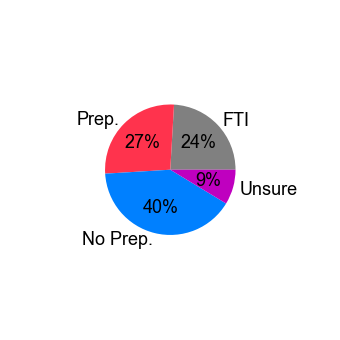

In [14]:
df_temp = pd.DataFrame({
    'condition':['FTI','Prep.','No Prep.','Unsure'],
    'percents':[24.1,26.9,40.4,8.67]
})

fig = plt.figure(figsize=(6,6))
plt.pie(df_temp.percents.values,
        labels=df_temp.condition.values,
        colors=[(0.5,0.5,0.5),
               (1,0.2,0.3),
                (0,0.5,1),
               (0.75,0,0.75)],
       autopct='%.0f%%',
       radius=0.5,
       textprops={'font':'Arial','size':18})
# colors = sns.color_palette('pastel')[0:5]


plt.savefig(savepath+'behavioral/pie.svg',bbox_inches='tight')
plt.savefig(savepath+'behavioral/pie.png',bbox_inches='tight')

plt.show()


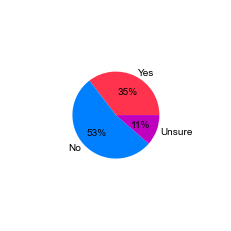

In [66]:
df_temp = pd.DataFrame({
    'condition':['Yes','No','Unsure'],
    'percents':[26.9,40.4,8.67]
})

plt.pie(df_temp.percents.values,
        labels=df_temp.condition.values,
        colors=[(1,0.2,0.3),
                (0,0.5,1),
               (0.75,0,0.75)],
       autopct='%.0f%%',
       radius=0.5,
       textprops={'font':'Arial'})
# colors = sns.color_palette('pastel')[0:5]


plt.savefig(savepath+'behavioral/pie_noFTI.svg',bbox_inches='tight')
plt.savefig(savepath+'behavioral/pie_noFTI.png',bbox_inches='tight')

plt.show()


# Descriptive Plots

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/waittimes.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/waittimes.png


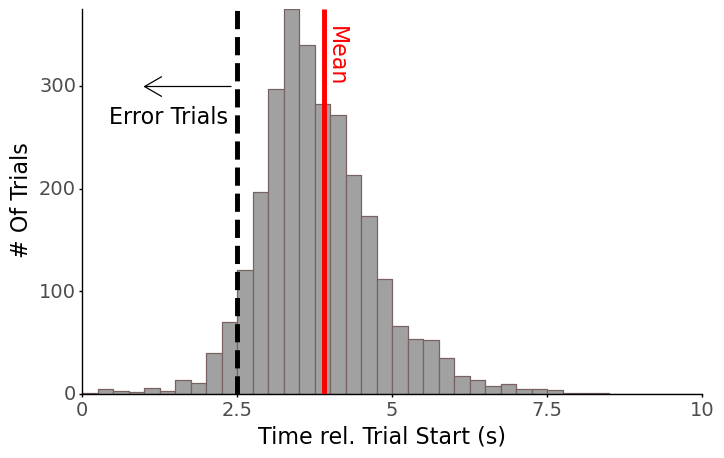

<ggplot: (453423017)>

In [9]:
df_temp = df[df.condition.isin(['RP'])]

wait_mean = np.nanmean(df_temp.wait_times.values[df_temp.wait_times.values > 2.5])
wait_median = np.nanmedian(df_temp.wait_times.values[df_temp.wait_times.values > 2.5])

p = (ggplot(df_temp,aes(x='wait_times'))+
     geom_histogram(binwidth=0.25,color='#7A6262',fill='#A1A1A1',boundary=2.5) +
     scale_x_continuous(name='Time rel. Trial Start (s)',limits=(0,10),expand=(0,0)) + 
     scale_y_continuous(name='# Of Trials',expand=(0,0)) +
     annotate("segment",x=2.4,xend=1.,y=300,yend=300,arrow=arrow()) +
     annotate("text",x=1.4,y=270,label="Error Trials",size=16)+
     theme_classic() +
    geom_vline(xintercept=wait_mean,color='red',size=2)+
     annotate("text",x=wait_mean*1.05,y=330,label="Mean",size=16,color='red',angle=270)+
#     geom_vline(xintercept=wait_median,linetype='--',color='blue') +
     geom_vline(xintercept=2.5,linetype='--',color='black',size=2) +
     theme(figure_size=(8,5),
          legend_position='none',
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16))
     



    )

p.save(savepath+"behavioral/waittimes.svg")
p.save(savepath+"behavioral/waittimes.png")

p

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/supp_waittimes_bysub.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 52'. Pick better value with 'binwidth'.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/supp_waittimes_bysub.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 52'. Pick better value with 'binwidth'.
/Users

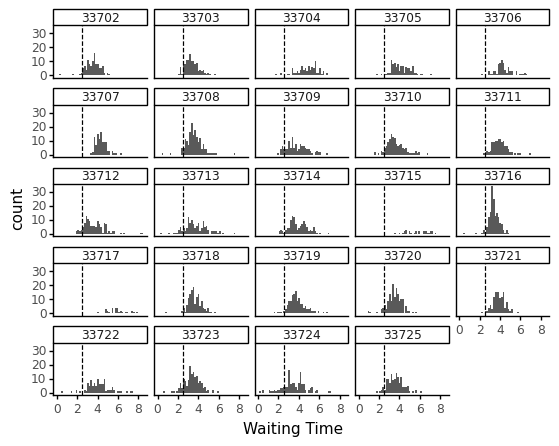

<ggplot: (443906482)>

In [16]:
df_temp = df[df.condition.isin(['RP'])]

p = (ggplot(df_temp,aes(x='wait_times'))+
     geom_histogram() +
     facet_wrap('~subject') +
     scale_x_continuous(name='Waiting Time') +
     theme_classic() +
     geom_vline(xintercept=2.5,linetype='--')

    )

p.save(savepath+'behavioral/supp_waittimes_bysub.svg')
p.save(savepath+'behavioral/supp_waittimes_bysub.png')

p

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/probetimes.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/probetimes.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9

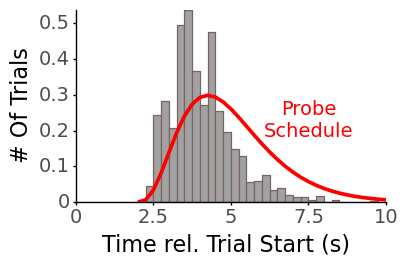

<ggplot: (453539666)>

In [19]:
df_temp = df[~df.condition.isin(['RP'])]

shape, scale = 4., 0.75  # mean=4, std=2*sqrt(2)

bins = np.arange(0,11,0.25)
import scipy.special as sps 
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))


df_gamma = pd.DataFrame({
    'probe_times':bins+2,
    'gamma':y
})

p = (ggplot(df_temp,aes(x='probe_times',y=after_stat('density')))+
     geom_histogram(binwidth=0.25,color='#7A6262',fill='#A1A1A1',boundary=2.5) +
     geom_line(aes(y='gamma'),data=df_gamma,color='red',size=1.5)+

     scale_x_continuous(name='Time rel. Trial Start (s)',limits=(0,10),expand=(0,0)) + 
     scale_y_continuous(name='# Of Trials',expand=(0,0)) +
          annotate("text",x=7.5,y=0.23,label="Probe\nSchedule",size=14,color='red',angle=0)+

     theme_classic() +
#     geom_vline(xintercept=wait_median,linetype='--',color='blue') +
     theme(figure_size=(4,2.5),
          legend_position='none',
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16))
     



    )

p.save(savepath+"behavioral/probetimes.svg")
p.save(savepath+"behavioral/probetimes.png")

p

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/FTItimes.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/FTItimes.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plo

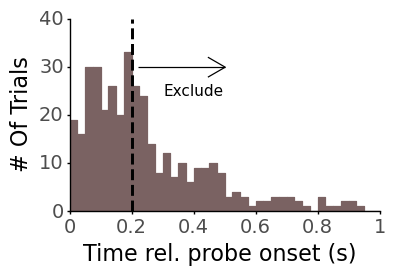

<ggplot: (446035219)>

In [22]:
df_temp = df[df.condition.isin(['FTI'])]



p = (ggplot(df_temp,aes(x='fti_time'))+
     geom_histogram(binwidth=0.025,fill='#7A6262',color='#7A6262',boundary=0.5) +
     annotate("segment",x=0.22,xend=0.5,y=30,yend=30,arrow=arrow()) +
     annotate("text",x=0.4,y=25,label="Exclude")+
     scale_x_continuous(name='Time rel. probe onset (s)',limits=(0,1),expand=(0,0),breaks=np.arange(0,1.1,0.2)) + 
     scale_y_continuous(name='# Of Trials',limits=(0,40),expand=(0,0)) +
     theme_classic() +
    geom_vline(xintercept=0.2,linetype='--',color='black',size=1.2) +
     theme(figure_size=(4,2.5),
          legend_position=(0.7,0.6),
           legend_title = element_blank(),
           legend_background = element_blank(),
           legend_text = element_text(size=14),
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16))
     



    )

p.save(savepath+"behavioral/FTItimes.svg")
p.save(savepath+"behavioral/FTItimes.png")

p

# Time-dependency of probe-related variables

Formula: isprobe~event_times+(event_times|subject)

Family: binomial	 Inference: parametric

Number of observations: 4640	 Groups: {'subject': 24.0}

Log-likelihood: -2812.328 	 AIC: 5634.655

Random effects:

                Name    Var    Std
subject  (Intercept)  4.525  2.127
subject  event_times  0.112  0.335

                 IV1          IV2   Corr
subject  (Intercept)  event_times -0.938

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -0.339  -1.245    0.567  0.462  0.713      0.288       1.764   
event_times    -0.005  -0.161    0.150  0.079  0.995      0.852       1.162   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val Sig  
(Intercept)  0.416        0.224         0.638  -0.733  0.464      
event_times  0.499        0.460         0.537  -0.069  0.945      


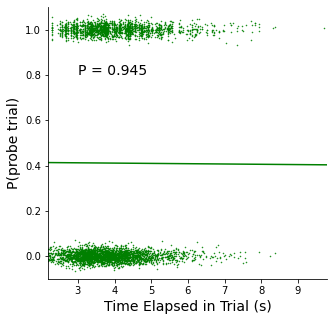

In [21]:
# See if being a probe trial is more likely as time goes on
df_probe = df[(df.event_times > 0)].copy()
df_probe['isprobe'] = df_probe.isprobe.astype('bool')
df_probe.drop(['wait_times','fti_time'],axis=1,inplace=True)

model = Lmer('isprobe ~ event_times + (event_times|subject)',data=df_probe,family='binomial')
print(model.fit())

intercept = model.coefs['Estimate'][0] # intercept
slope = model.coefs['Estimate'][1] 
# slopes = model.fixef['probe_times']
times = np.linspace(0,10,100)
logits = intercept + slope * times
probs_probe = np.exp(logits)/(1 + np.exp(logits))

pval_probe = model.coefs['P-val'][1]


fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_probe,'-g')

ax.plot(df_probe.event_times.values,df_probe.isprobe.values+np.random.randn(df_probe.isprobe.values.shape[0])*0.02,'.g',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df.probe_times.values)-0.1,np.nanmax(df.probe_times.values)+0.1)
ax.set_ylabel('P(probe trial)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'behavioral/prob_probe.svg')
plt.savefig(savepath+'behavioral/prob_probe.png')


plt.show()

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hist_isprobe.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 2813 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 1827 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/Users/gavenas/opt/anacon

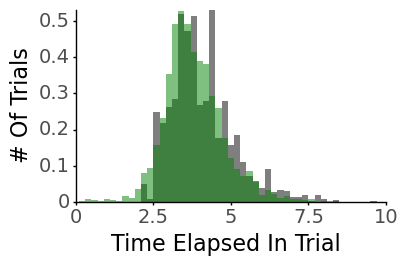

<ggplot: (451127300)>

In [22]:
df_temp = df.copy()
df_temp['trialtype'] = 'no'
df_temp.loc[df_temp.isprobe,'trialtype'] = 'yes'
p = (ggplot(df_temp,aes(fill='trialtype'))+
     geom_histogram(aes(x='probe_times',y=after_stat('density')),binwidth=0.2,color=None,alpha = 0.5,fill='black') +
      geom_histogram(aes(x='wait_times',y=after_stat('density')),binwidth=0.2,color=None,alpha = 0.5,fill='green') +

     scale_x_continuous(name='Time Elapsed In Trial',limits=(0,10),expand=(0,0)) + 
     scale_y_continuous(name='# Of Trials',expand=(0,0)) +
     theme_classic() +
#     geom_vline(xintercept=wait_median,linetype='--',color='blue') +
     theme(figure_size=(4,2.5),
          legend_position=(0.7,0.6),
           legend_title = element_blank(),
           legend_background = element_blank(),
           legend_text = element_text(size=14),
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16))
     



    )

p.save(savepath+'behavioral/hist_isprobe.svg')
p.save(savepath+'behavioral/hist_isprobe.png')

p

Formula: ishit~probe_times+(probe_times|subject)

Family: binomial	 Inference: parametric

Number of observations: 1283	 Groups: {'subject': 24.0}

Log-likelihood: -721.002 	 AIC: 1452.003

Random effects:

                Name    Var    Std
subject  (Intercept)  5.877  2.424
subject  probe_times  0.076  0.276

                 IV1          IV2   Corr
subject  (Intercept)  probe_times -0.871

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.078  -3.266   -0.891  0.606  0.125      0.038       0.410   
probe_times     0.322   0.131    0.513  0.098  1.380      1.140       1.671   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.111        0.037         0.291  -3.429  0.001  ***  
probe_times  0.580        0.533         0.626   3.300  0.001  ***  


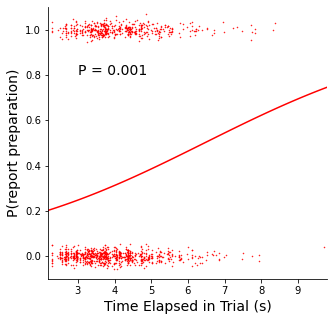

In [23]:
# See if a probe trial being a hit is more likely as time goes on
df_probe = df[df.condition.isin(['Miss','Hit']) & (df.probe_times > 0)].copy()
df_probe['ishit'] = df_probe.condition.str.match('Hit').astype('bool')
df_probe.drop(['wait_times','fti_time'],axis=1,inplace=True)

model = Lmer('ishit ~ probe_times + (probe_times|subject)',data=df_probe,family='binomial')
print(model.fit())

ranef_hit = model.fixef['probe_times'].values


intercept = model.coefs['Estimate'][0] # intercept
slope = model.coefs['Estimate'][1] 
# slopes = model.fixef['probe_times']
times = np.linspace(0,10,100)
logits = intercept + slope * times
probs_hit = np.exp(logits)/(1 + np.exp(logits))

pval_hit = model.coefs['P-val'][1]


fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_probe.probe_times.values,df_probe.ishit.values+np.random.randn(df_probe.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df.probe_times.values)-0.1,np.nanmax(df.probe_times.values)+0.1)
ax.set_ylabel('P(report preparation)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'behavioral/prob_hit.svg')
plt.savefig(savepath+'behavioral/prob_hit.png')


plt.show()

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hist_ishit.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 799 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 484 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hist_ishit.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-pack

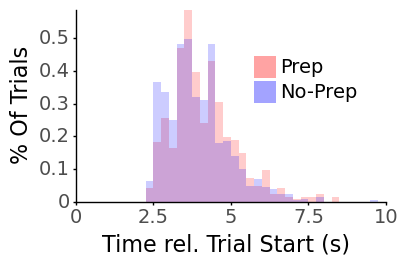

<ggplot: (450538054)>

In [24]:
df_temp = df_probe.copy()
df_temp['hit_times'] = np.nan
df_temp.loc[df_temp.ishit,'hit_times'] = df_temp.loc[df_temp.ishit,'event_times']
df_temp['miss_times'] = np.nan
df_temp.loc[~df_temp.ishit,'miss_times'] = df_temp.loc[~df_temp.ishit,'event_times']

p = (ggplot(df_temp,aes(fill='condition',))+
     geom_histogram(aes(x='hit_times',y=after_stat('density')),binwidth=0.25,color=None,alpha = 0.2,boundary=2.5) +
      geom_histogram(aes(x='miss_times',y=after_stat('density')),binwidth=0.25,color=None,alpha = 0.2,boundary=2.5) +

     scale_x_continuous(name='Time rel. Trial Start (s)',limits=(0,10),expand=(0,0)) + 
     scale_y_continuous(name='% Of Trials',expand=(0,0)) +
     scale_fill_manual(values=['red','blue'],labels=['Prep','No-Prep'])+
     theme_classic() +
#     geom_vline(xintercept=wait_median,linetype='--',color='blue') +
     theme(figure_size=(4,2.5),
          legend_position=(0.7,0.6),
           legend_title = element_blank(),
           legend_background = element_blank(),
           legend_text = element_text(size=14),
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16))
     



    )

p.save(savepath+'behavioral/hist_ishit.svg')
p.save(savepath+'behavioral/hist_ishit.png')


p

Formula: isfti~probe_times+(probe_times|subject)

Family: binomial	 Inference: parametric

Number of observations: 1827	 Groups: {'subject': 24.0}

Log-likelihood: -770.608 	 AIC: 1551.216

Random effects:

                Name    Var    Std
subject  (Intercept)  4.930  2.220
subject  probe_times  0.103  0.321

                 IV1          IV2   Corr
subject  (Intercept)  probe_times -0.821

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -3.366  -4.466   -2.266  0.561  0.035      0.011       0.104   
probe_times     0.477   0.274    0.680  0.103  1.611      1.316       1.973   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.033        0.011         0.094  -5.997    0.0  ***  
probe_times  0.617        0.568         0.664   4.616    0.0  ***  


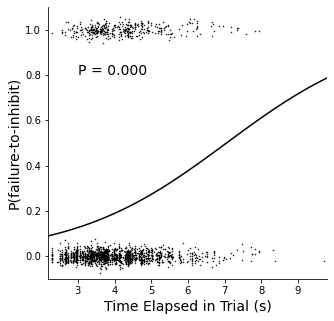

In [25]:
# Whether a probe trial is more likely to be a labeled an FTI trial as time goes on.
df_fti = df[(df.probe_times > 0)&(df.isprobe.astype('bool'))].copy()

df_fti.drop(['wait_times','fti_time'],axis=1,inplace=True)

model = Lmer('isfti ~ probe_times + (probe_times|subject)',data=df_fti,family='binomial')
print(model.fit())

ranef_fti = model.fixef['probe_times'].values

intercept = model.coefs['Estimate'][0] # intercept
slope = model.coefs['Estimate'][1] 
# slopes = model.fixef['probe_times']
times = np.linspace(0,10,100)
logits = intercept + slope * times
probs_fti = np.exp(logits)/(1 + np.exp(logits))

pval_fti = model.coefs['P-val'][1]

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_fti.probe_times.values,df_fti.isfti.values+np.random.randn(df_fti.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df.probe_times.values)-0.1,np.nanmax(df.probe_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'behavioral/prob_fti.svg')
plt.savefig(savepath+'behavioral/prob_fti.png')

plt.show()

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hist_isfti.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 1451 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 376 rows containing non-finite values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2.5 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hist_isfti.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-pac

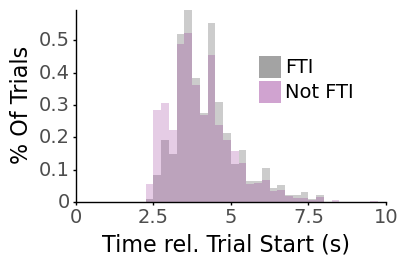

<ggplot: (450243949)>

In [26]:
df_temp = df_fti.copy()
df_temp['fti_times'] = np.nan
df_temp.loc[df_temp.isfti.astype('bool'),'fti_times'] = df_temp.loc[df_temp.isfti.astype('bool'),'event_times']
df_temp.loc[df_temp.isfti.astype('bool'),'condition'] = 'fti'
df_temp['inh_times'] = np.nan
df_temp.loc[~df_temp.isfti.astype('bool'),'inh_times'] = df_temp.loc[~df_temp.isfti.astype('bool'),'event_times']
df_temp.loc[~df_temp.isfti.astype('bool'),'condition'] = 'notfti'

p = (ggplot(df_temp,aes(fill='condition',))+
     geom_histogram(aes(x='fti_times',y=after_stat('density')),binwidth=0.25,color=None,alpha = 0.2,boundary=2.5) +
      geom_histogram(aes(x='inh_times',y=after_stat('density')),binwidth=0.25,color=None,alpha = 0.2,boundary=2.5) +

     scale_x_continuous(name='Time rel. Trial Start (s)',limits=(0,10),expand=(0,0)) + 
     scale_y_continuous(name='% Of Trials',expand=(0,0)) +
     scale_fill_manual(values=['black','purple'],labels=['FTI','Not FTI'])+
     theme_classic() +
#     geom_vline(xintercept=wait_median,linetype='--',color='blue') +
     theme(figure_size=(4,2.5),
          legend_position=(0.7,0.6),
           legend_title = element_blank(),
           legend_background = element_blank(),
           legend_text = element_text(size=14),
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16))
     



    )

p.save(savepath+'behavioral/hist_isfti.svg')
p.save(savepath+'behavioral/hist_isfti.png')


p

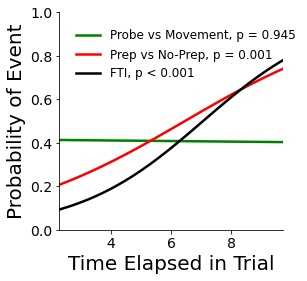

In [41]:
fig = plt.figure(figsize=(4,4))

ax = plt.gca()

ax.plot(times,probs_probe,'-g',label=f"Probe vs Movement, p = {pval_probe:.3f}",linewidth=2.5)
ax.plot(times,probs_hit,'-r',label=f"Prep vs No-Prep, p = {pval_hit:.3f}",linewidth=2.5)
ax.plot(times,probs_fti,'-k',label=f"FTI, p < 0.001",linewidth=2.5)

# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.probe_times.values),color='gray',linestyle='--')
# ax.axvline(np.nanmax(df.probe_times.values),color='gray',linestyle='--')
ax.set_ylim(0,1)
ax.set_xlim(np.nanmin(df.probe_times.values),np.nanmax(df.probe_times.values))
ax.set_ylabel('Probability of Event',fontsize=20)
ax.set_xlabel('Time Elapsed in Trial',fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.legend(loc='upper left',markerscale=5,frameon=False,facecolor='white',borderaxespad=1,fontsize=12)
plt.savefig(savepath+'behavioral/prob_all.svg',bbox_inches='tight')
plt.savefig(savepath+'behavioral/prob_all.png',bbox_inches='tight')
plt.show()

In [89]:
df_motprep = pd.DataFrame({'fti':ranef_fti,'hit':ranef_hit})

model = Lm('fti ~ hit',data=df_motprep)

print(model.fit())

Formula: fti~hit

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 13	 R^2: 0.060	 R^2_adj: -0.026

Log-likelihood: 3.753 	 AIC: -3.506	 BIC: -2.376

Fixed effects:

           Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val Sig
Intercept     0.492   0.223    0.761  0.122  11   4.022  0.002  **
hit          -0.270  -0.980    0.441  0.323  11  -0.835  0.422    


In [46]:
# See if a probe trial being a hit is more likely as time goes on
df_probe = df[df.condition.isin(['Miss','Hit']) & (df.probe_times > 0)].copy()
df_probe['ishit'] = df_probe.condition.str.match('Hit').astype('bool')
df_probe.drop(['wait_times','fti_time'],axis=1,inplace=True)

model = Lmer('probe_times ~ condition + (condition|subject)',data=df_probe)
print(model.fit())


Formula: probe_times~condition+(condition|subject)

Family: gaussian	 Inference: parametric

Number of observations: 1283	 Groups: {'subject': 24.0}

Log-likelihood: -1800.825 	 AIC: 3601.649

Random effects:

                   Name    Var    Std
subject     (Intercept)  0.222  0.471
subject   conditionMiss  0.085  0.291
Residual                 0.924  0.961

                 IV1            IV2  Corr
subject  (Intercept)  conditionMiss -0.78

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)       4.038   3.814    4.261  0.114  20.233  35.386  0.000  ***
conditionMiss    -0.229  -0.411   -0.047  0.093  20.125  -2.468  0.023    *


Formula: probe_times~0+condition+(condition|subject)

Family: gaussian	 Inference: parametric

Number of observations: 1283	 Groups: {'subject': 24.0}

Log-likelihood: -1800.825 	 AIC: 3601.649

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.093  0.305
subject   conditionHit  0.085  0.291
Residual                0.924  0.961

                 IV1           IV2   Corr
subject  (Intercept)  conditionHit  0.251

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
conditionMiss     3.808   3.663    3.954  0.074  22.071  51.260    0.0  ***
conditionHit      4.038   3.814    4.261  0.114  20.234  35.387    0.0  ***


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2 x 2 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hitVmiss_times.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2 x 2 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/behavioral/hitVmiss_times.png


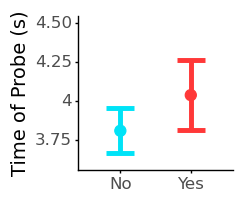

<ggplot: (454436322)>

In [88]:
model = Lmer('probe_times ~ 0 + condition + (condition|subject)',data=df_probe)
#     print(model.fit())
print(model.fit(factors={"condition":['Miss','Hit']}))

df_lmeEst = pd.DataFrame({
    'condition':['No','Yes'],
    'wait_time':[model.coefs['Estimate'][0],model.coefs['Estimate'][1]],
    'CIlow':[model.coefs['2.5_ci'][0],model.coefs['2.5_ci'][1]],
    'CIhigh':[model.coefs['97.5_ci'][0],model.coefs['97.5_ci'][1]]
})

p = (ggplot(df_lmeEst,aes(x='condition',y='wait_time',color='condition',fill='condition')) +

     scale_x_discrete(name='Condition',limits=['No','Yes']) +
     geom_errorbar(aes(y='wait_time',ymin='CIlow',ymax='CIhigh'),size=2,width=0.4) +
     geom_point(aes(y='wait_time'),data=df_lmeEst,size=4) +
#  scale_y_continuous(breaks=np.arange(-15,36,5),limits=(-15,38)) +
   scale_y_continuous(name='Time of Probe (s)',limits=(3.6,4.5),breaks=np.arange(3.75,5.1,0.25)) +
   scale_color_manual(name='Condition',values=['#00E3F7','#FF3838'])+
     scale_fill_manual(values=['#00E3F7','#FF3838']) +
#  labs(title='Anticipatory Pupil Dilations') +
 theme_classic() +
   theme(legend_position='none',
        axis_text = element_text(size=12),
       axis_ticks_length = 2,
       axis_title_y = element_text(size=14),
         axis_title_x = element_blank(),
        figure_size = (2,2)) 
)

p.save(savepath+'behavioral/hitVmiss_times.svg')
p.save(savepath+'behavioral/hitVmiss_times.png')


p

Formula: probe_times~0+condition+(condition|subject)

Family: gaussian	 Inference: parametric

Number of observations: 1283	 Groups: {'subject': 24.0}

Log-likelihood: -1800.825 	 AIC: 3601.649

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.093  0.305
subject   conditionHit  0.085  0.291
Residual                0.924  0.961

                 IV1           IV2   Corr
subject  (Intercept)  conditionHit  0.251

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
conditionMiss     3.808   3.663    3.954  0.074  22.071  51.260    0.0  ***
conditionHit      4.038   3.814    4.261  0.114  20.234  35.387    0.0  ***


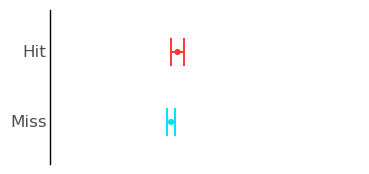

<ggplot: (453739813)>

In [62]:
model = Lmer('probe_times ~ 0 + condition + (condition|subject)',data=df_probe)
#     print(model.fit())
print(model.fit(factors={"condition":['Miss','Hit']}))

df_lmeEst = pd.DataFrame({
    'condition':['Miss','Hit'],
    'wait_time':[model.coefs['Estimate'][0],model.coefs['Estimate'][1]],
    'CIlow':[model.coefs['2.5_ci'][0],model.coefs['2.5_ci'][1]],
    'CIhigh':[model.coefs['97.5_ci'][0],model.coefs['97.5_ci'][1]]
})

p = (ggplot(df_lmeEst,aes(y='condition',x='wait_time',color='condition',fill='condition')) +

     scale_y_discrete(name='Condition',limits=['Miss','Hit']) +
     geom_errorbarh(aes(x='wait_time',xmin='CIlow',xmax='CIhigh'),size=0.8,height=0.4) +
     geom_point(aes(x='wait_time'),data=df_lmeEst,size=1.5) +
#  scale_y_continuous(breaks=np.arange(-15,36,5),limits=(-15,38)) +
   scale_x_continuous(name='Time of Probe (s)',limits=(0,10)) +
   scale_color_manual(name='Condition',values=['#FF3838','#00E3F7'])+
     scale_fill_manual(values=['#FF3838','#00E3F7']) +
#  labs(title='Anticipatory Pupil Dilations') +
 theme_classic() +
   theme(legend_position='none',
        axis_text = element_text(size=12),
       axis_ticks_length = 0,
#        axis_title_y = element_text(size=14),
         axis_title = element_blank(),
         axis_text_x = element_blank(),
         axis_line_x = element_blank(),
        figure_size = (4,2)) 
)

# p.save(savepath+'behavioral/hitVmiss_times.svg')
# p.save(savepath+'behavioral/hitVmiss_times.png')


p